In [ ]:
import os
import sys

# Redirigir stdout y stderr a devnull
class NullIO:
    def write(self, *args, **kwargs):
        pass
    def flush(self):
        pass

sys.stdout = NullIO()
sys.stderr = NullIO()


Actualizar bigframes y scikit-learn a sus versiones más recientes y luego reinstalar imbalanced-learn:

In [ ]:
!pip install --upgrade bigframes
!pip install --upgrade scikit-learn
!pip install --upgrade imbalanced-learn

Instalar una versión de imbalanced-learn que sea compatible con la versión más reciente de scikit-learn:

In [ ]:
!pip install scikit-learn
!pip install imbalanced-learn

Cargar librerías:

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
import lightgbm as lgb

# 1. Cargar los datos:

In [ ]:
df = pd.read_csv('/content/creditcard_csv.csv')

#2. Mostrar las primeras filas del dataframe para verificar que se ha cargado correctamente:

In [ ]:
print(df.head())

   Time        V1        V2        V3        V4        V5        V6        V7  \
0     0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1     0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2     1 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3     1 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4     2 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

# 3. Ver la distribución de la variable dependiente 'Class' (Observamos que el conjunto de datos está altamente desbalanceado):

In [ ]:
print(df['Class'].value_counts())

Class
'0'    144112
'1'       280
Name: count, dtype: int64


# 4. Limpiar la columna 'Class' y convertir a entero:

In [ ]:
print("Valores únicos en la columna 'Class':", df['Class'].unique())

Valores únicos en la columna 'Class': ['0' '1' 'nan']



# 5. Limpiar la columna 'Class' y convertir a entero, eliminando filas con 'nan':

In [ ]:
df['Class'] = df['Class'].astype(str).str.replace("'", "").str.strip()  # Elimina comillas y espacios
df = df.dropna(subset=['Class'])  # Eliminar filas con valores 'nan'
df = df[df['Class'].str.isnumeric()]  # Mantener solo valores numéricos
df.loc[:, 'Class'] = df['Class'].astype(int)  # Convertir a entero

# 6. Separar las características (X) y la variable objetivo (y):

In [ ]:
X = df.drop(columns=['Class'])
y = df['Class']

# 7. Dividir el conjunto de datos en entrenamiento y prueba:

In [ ]:
print("Valores únicos en la variable objetivo:", y.unique())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=90)
print("Tipos de datos en y_train:", y_train.dtypes)
print("Valores únicos en y_train:", y_train.unique())
y_train = y_train.astype(int)
print("Tipos de datos en y_train:", y_train.dtypes)

Valores únicos en la variable objetivo: [0 1]
Tipos de datos en y_train: object
Valores únicos en y_train: [0 1]
Tipos de datos en y_train: int64


#8. Aplicar over-sampling a los datos de entrenamiento para balancear las clases (previamente se aplicó una técnica de under-sampling pero los resultados no fueron satisfactorios):

In [ ]:
smote = SMOTE(random_state=0)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

#9. Ver la distribución de las clases en el conjunto de entrenamiento después de aplicar over-sampling:

In [ ]:
print("Número de clases antes de oversampling:")
print(y_train.value_counts())
print("\nNúmero de clases después de oversampling:")
print(y_train_res.value_counts())


Número de clases antes de oversampling:
Class
0    86470
1      165
Name: count, dtype: int64

Número de clases después de oversampling:
Class
0    86470
1    86470
Name: count, dtype: int64


#10. Visualizar los datos antes y después del oversampling (usando los primeros dos componentes principales)

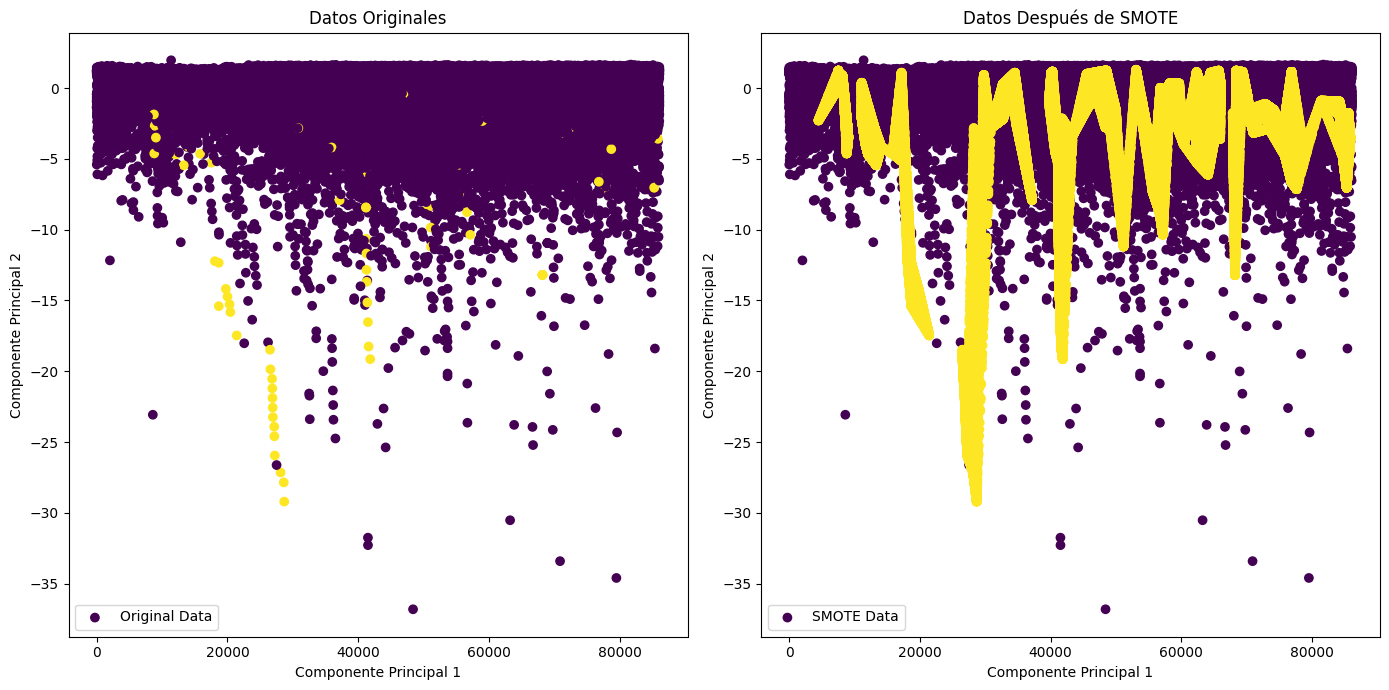

In [ ]:
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.scatter(X_train.iloc[:, 0], X_train.iloc[:, 1], c=y_train, marker='o', label='Original Data')
plt.title('Datos Originales')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(X_train_res.iloc[:, 0], X_train_res.iloc[:, 1], c=y_train_res, marker='o', label='SMOTE Data')
plt.title('Datos Después de SMOTE')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend()

plt.tight_layout()
plt.show()

#11. Configurar y entrenar el modelo LightGBM:

In [ ]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'num_leaves': 100,
    'max_depth': 20,
    'learning_rate': 0.1,
    'n_estimators': 200
}

lgb_train = lgb.Dataset(X_train_res, y_train_res)
lgb_model = lgb.train(params, lgb_train, num_boost_round=100)

# 12. Realizar predicciones

In [ ]:
y_pred = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)

#13. Ajustar el umbral para convertir probabilidades a etiquetas binarias y asegurarse que el tipo de datos con el que vamos a trabajar es el correcto.

In [ ]:
umbral = 0.7
y_pred_adjusted = [1 if prob >= umbral else 0 for prob in y_pred]
y_pred_adjusted = np.array(y_pred_adjusted, dtype=int)
print("Tipos de datos en y_pred_adjusted:", y_pred_adjusted.dtype)
print("Valores únicos en y_pred_adjusted:", np.unique(y_pred_adjusted))
y_test = y_test.astype(int)

Tipos de datos en y_pred_adjusted: int64
Valores únicos en y_pred_adjusted: [0 1]
Tipos de datos en y_test: object


#14. Evaluar el modelo

In [ ]:
print("Accuracy Score:", accuracy_score(y_test, y_pred_adjusted))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_adjusted))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_adjusted))


Accuracy Score: 0.999584465952179

Confusion Matrix:
[[57634     8]
 [   16    99]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     57642
           1       0.93      0.86      0.89       115

    accuracy                           1.00     57757
   macro avg       0.96      0.93      0.95     57757
weighted avg       1.00      1.00      1.00     57757




Como podemos observar el modelo tiene una precisión muy alta en general de 0.999.
    

   57634: Verdaderos negativos (correctamente predicho como clase 0).


   8: Falsos positivos (incorrectamente predicho como clase 1).
  
  16: Falsos negativos (incorrectamente predicho como clase 0).


  99: Verdaderos positivos (correctamente predicho como clase 1)



  El modelo predice casi perfectamente las transacciones que no son fraudulentas. Esto es esperado dado que la clase 0 es la clase mayoritaria en los datos.
  
  Sin embargo, en cuanto a la clase 1 (Fraude). Precisión: De todas las transacciones predichas como fraudulentas, el 93% realmente lo son. Esta alta precisión es crucial para minimizar los falsos positivos. Recall: El modelo detecta el 86% de todas las transacciones fraudulentas reales. Un alto recall es vital para asegurar que la mayoría de los fraudes sean identificados.


  Tanto la precisión como el recall de la clase 1 son mejorables, pero teniendo en cuenta que estamos ante un conjunto de datos que se ha balanceado gracias a la creación de datos artificiales con el over-sampling, podemos confirmar que tenemos valores muy aceptables para ambos indicadores, ya que analizando directamente el conjunto de datos original los valores fueron cercanos a 0.









#15. Crear una tabla con las probabilidades de fraude para cada transacción en el conjunto de prueba:

In [ ]:
resultados = pd.DataFrame({
    'Probabilidad_Fraude': np.round(y_pred, 5).astype(str),  # Probabilidades de fraude
    'Prediccion': y_pred_adjusted    # Predicciones ajustadas
})

# Concatenar las características originales con los resultados
resultados_completos = pd.concat([X_test.reset_index(drop=True), resultados.reset_index(drop=True)], axis=1)

# Guardar en un archivo Excel
resultados_completos.to_excel('resultados_fraude.xlsx', index=False)



#Exportar el notebook a formato HTML

In [4]:
from google.colab import files
import nbformat
from nbconvert import HTMLExporter

# Cargar el archivo del notebook
notebook_filename = '/content/Fraud_detection.ipynb'
with open(notebook_filename) as f:
    notebook_content = nbformat.read(f, as_version=4)

# Exportar a HTML
html_exporter = HTMLExporter()
(body, resources) = html_exporter.from_notebook_node(notebook_content)

# Guardar el archivo HTML
with open('notebook_exportado.html', 'w') as f:
    f.write(body)

# Descargar el archivo HTML
files.download('notebook_exportado.html')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>